In [1]:
!pip install torch TorchCRF seqeval transformers --quiet

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*?seems not to be NE tag.*?")

In [2]:
from utils import *

/users/eleves-a/2021/ivan.tchomba-ngueko/ensae/concept-ner/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
labels, labels_vocab, labels_vocab_inv = get_labels()

In [4]:
len(labels_vocab.values())

59

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
from transformers import AutoModel, AutoTokenizer
from TorchCRF import CRF
import numpy as np
from seqeval.metrics import f1_score, precision_score, recall_score, classification_report
from tqdm import tqdm
import os
import pickle


In [6]:
# Configuration
class Config:
    model_name = "microsoft/deberta-v3-base"
    max_length = 80
    batch_size = 128  # Peut être augmenté car moins de mémoire nécessaire
    epochs = 100      # Peut être augmenté car entraînement plus rapide

    learning_rate = 1e-3  # Peut être plus élevé car moins de paramètres
    lstm_hidden_dim = 256
    lstm_layers = 2
    lstm_dropout = 0.3
    num_labels = len(labels)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    embeddings_dir = "precalculated_embeddings"

    ignore_index = -100

config = Config()


In [7]:
from datasets import Dataset

In [8]:

# Étape 1: Créer une fonction pour précalculer les embeddings DeBERTa
# def precalculate_embeddings(texts, tags, tokenizer, max_length, output_dir, split_name):
#     """Précalcule et sauvegarde les embeddings DeBERTa pour un ensemble de données"""
#     # Créer le répertoire de sortie s'il n'existe pas
#     os.makedirs(output_dir, exist_ok=True)
    
#     # Charger le modèle DeBERTa
#     print(f"Chargement du modèle {config.model_name}...")
#     model = AutoModel.from_pretrained(config.model_name).to(config.device)
#     model.eval()
    
#     # Préparer les structures pour stocker les données
#     all_embeddings = []
#     all_attention_masks = []
#     all_labels = []
#     tag2id = {tag: id for id, tag in enumerate(sorted(set([t for seq in tags for t in seq])))}
#     id2tag = {id: tag for tag, id in tag2id.items()}
    
#     # Traitement batch par batch pour éviter les problèmes de mémoire
#     batch_size = 16
#     num_batches = (len(texts) + batch_size - 1) // batch_size
    
#     print(f"Précalcul des embeddings pour {len(texts)} séquences...")
    
#     for i in tqdm(range(num_batches)):
#         start_idx = i * batch_size
#         end_idx = min((i + 1) * batch_size, len(texts))
#         batch_texts = texts[start_idx:end_idx]
#         batch_tags = tags[start_idx:end_idx]
        
#         # Traiter chaque exemple du batch
#         for text, tags_seq in zip(batch_texts, batch_tags):
#             # Tokeniser
#             encoding = tokenizer(
#                 text,
#                 is_split_into_words=True,
#                 max_length=max_length,
#                 padding='max_length',
#                 truncation=True,
#                 return_tensors='pt'
#             )
            
#             input_ids = encoding['input_ids'].to(config.device)
#             attention_mask = encoding['attention_mask'].to(config.device)
            
#             # Calculer les embeddings avec DeBERTa (sans gradient)
#             with torch.no_grad():
#                 outputs = model(input_ids=input_ids, attention_mask=attention_mask)
#                 embeddings = outputs.last_hidden_state.cpu()  # [1, seq_len, hidden_dim]
            
#             # Préparer les étiquettes
#             word_ids = encoding.word_ids()
#             label_ids = torch.full((max_length,), -100, dtype=torch.long)
            
#             # Mapping des tags aux tokens
#             previous_word_id = None
#             for j, word_id in enumerate(word_ids):
#                 if word_id is None or word_id == previous_word_id:
#                     continue
#                 elif word_id < len(tags_seq):
#                     label_ids[j] = tag2id[tags_seq[word_id]]
#                 previous_word_id = word_id
            
#             # Stocker les données
#             all_embeddings.append(embeddings.squeeze(0))  # [seq_len, hidden_dim]
#             all_attention_masks.append(attention_mask.cpu().squeeze(0))  # [seq_len]
#             all_labels.append(label_ids)  # [seq_len]
    
#     # Convertir en tensors
#     all_embeddings = torch.stack(all_embeddings)  # [n_samples, seq_len, hidden_dim]
#     all_attention_masks = torch.stack(all_attention_masks)  # [n_samples, seq_len]
#     all_labels = torch.stack(all_labels)  # [n_samples, seq_len]
    
#     # Sauvegarder
#     print(f"Sauvegarde des embeddings et métadonnées...")
#     data = {
#         'embeddings': all_embeddings,
#         'attention_masks': all_attention_masks,
#         'labels': all_labels,
#         'tag2id': tag2id,
#         'id2tag': id2tag
#     }
    
#     with open(os.path.join(output_dir, f"{split_name}_data.pkl"), 'wb') as f:
#         pickle.dump(data, f)
    
#     print(f"Données sauvegardées dans {os.path.join(output_dir, f'{split_name}_data.pkl')}")
#     return tag2id, id2tag


In [9]:

# Étape 2: Créer le dataset qui utilise les embeddings précalculés
class EmbeddingsDataset(Dataset):
    def __init__(self, data_path, parts=None, complement='_5000'):
        # Charger les données précalculées
        # parts = 5
        data = [None] * parts
        for i in range(parts):
            index = f'_{i+1}' if parts > 1 else ''
            with open(data_path + index + f'{complement}_data.pkl', 'rb') as f:
                data[i] = pickle.load(f)
        
        self.embeddings = torch.cat([data[i]['embeddings'] for i in range(parts)], dim=0)
        self.attention_masks = torch.cat([data[i]['attention_masks'] for i in range(parts)], dim=0).to(torch.uint8)
        self.labels = torch.cat([data[i]['labels'] for i in range(parts)], dim=0).to(torch.long)
        self.labels[self.labels == config.ignore_index] = config.num_labels  # Remplacer -100 par num_labels
        self.tag2id = data[0]['tag2id']
        self.id2tag = data[0]['id2tag']

        # redo the labels
        for label, id in self.tag2id.items():
            if id == -100:
                continue
            self.labels[self.labels == id] = labels_vocab[label]
        self.tag2id = labels_vocab
        self.id2tag = labels_vocab_inv
    def __len__(self):
        return len(self.embeddings)
    
    def __getitem__(self, idx):
        return {
            'embeddings': self.embeddings[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }


In [ ]:

class LSTMCRFModel(nn.Module):
    def __init__(self, embedding_dim, config):
        super(LSTMCRFModel, self).__init__()
        self.num_labels = config.num_labels+1
        
        # Couche BiLSTM
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=config.lstm_hidden_dim,
            num_layers=config.lstm_layers,
            bidirectional=True,
            batch_first=True,
            dropout=config.lstm_dropout if config.lstm_layers > 1 else 0
        )
        
        # Layer normalization
        self.layer_norm = nn.LayerNorm(config.lstm_hidden_dim * 2)
        
        # Projection
        self.hidden2tag = nn.Linear(config.lstm_hidden_dim * 2, config.num_labels+1)  # +1 pour le label -100
        
        # Dropout
        self.dropout = nn.Dropout(0.2)
        
        # CRF
        self.crf = CRF(config.num_labels+1, use_gpu=config.device.type == 'cuda')
    
    def forward(self, embeddings, attention_mask, labels=None):
        # Appliquer le dropout aux embeddings précalculés
        embeddings = self.dropout(embeddings)
        
        # Passer par BiLSTM
        lstm_output, _ = self.lstm(embeddings)  # [batch_size, seq_len, lstm_hidden_dim*2]
        
        # Layer normalization
        lstm_output = self.layer_norm(lstm_output)
        
        # Dropout sur la sortie du LSTM
        lstm_output = self.dropout(lstm_output)
        
        # Projection pour obtenir les scores
        emissions = self.hidden2tag(lstm_output)  # [batch_size, seq_len, num_labels+1]
        
        mask = attention_mask.bool()

        # Si labels est fourni, calculer la perte
        if labels is not None:
            # Calculer la perte CRF
            loss = -self.crf(emissions, labels.to(torch.long), mask=mask).mean()
            return loss
        else:
            # Décodage pour l'inférence
            mask = attention_mask.bool()
            best_tags = self.crf.viterbi_decode(emissions, mask=mask)
            return best_tags


In [ ]:

def train(model, dataloader, optimizer, device, epoch):
    model.train()
    total_loss = 0
    
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}")
    for batch in progress_bar:
        optimizer.zero_grad()
        
        embeddings = batch['embeddings'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass
        loss = model(embeddings=embeddings, attention_mask=attention_mask, labels=labels)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # Mise à jour des paramètres
        optimizer.step()
        
        total_loss += loss.item()
        progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})
    
    return total_loss / len(dataloader)


In [ ]:

def evaluate(model, dataloader, id2tag, device):
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            embeddings = batch['embeddings'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].cpu().numpy()
            
            # Prédictions
            outputs = model(embeddings=embeddings, attention_mask=attention_mask)
            
            # Pour chaque séquence du batch
            for i, pred_seq in enumerate(outputs):
                pred_tags = []
                true_tags = []
                
                for j, pred_id in enumerate(pred_seq):
                    if j < len(attention_mask[i]) and attention_mask[i][j] == 1:
                        if labels[i][j] != 59:
                            true_tags.append(id2tag[labels[i][j]])
                        else: 
                            true_tags.append('JUNK')
                        if pred_id != 59:
                            pred_tags.append(id2tag[pred_id])
                        else:
                            pred_tags.append('JUNK')
                
                if true_tags:  # S'assurer qu'il y a des tags valides
                    predictions.append(pred_tags)
                    true_labels.append(true_tags)
    
    # Calculer les métriques
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    report = classification_report(true_labels, predictions, zero_division=0)
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'report': report
    }


In [12]:
train_data = EmbeddingsDataset('data/train', 4)
test_data = EmbeddingsDataset('data/test', 1, '')
val_data = EmbeddingsDataset('data/valid', 1, '')

In [13]:
# Obtenir les mappings tag<->id et mettre à jour config
tag2id = train_data.tag2id
id2tag = train_data.id2tag
# config.num_labels = len(tag2id)

# Créer les dataloaders
train_dataloader = DataLoader(train_data, batch_size=config.batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=config.batch_size)


In [14]:

# Obtenir la dimension des embeddings
embedding_dim = train_data.embeddings.size(-1)


In [16]:

# Initialiser le modèle
model = LSTMCRFModel(embedding_dim, config).to(config.device)
model

LSTMCRFModel(
  (lstm): LSTM(768, 256, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (hidden2tag): Linear(in_features=512, out_features=60, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (crf): CRF()
)

In [19]:

# Définir l'optimiseur
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)


/users/eleves-a/2021/ivan.tchomba-ngueko/ensae/concept-ner/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [20]:

train_history = [0] * config.epochs
# Entraînement
best_f1 = 0.0
for epoch in range(config.epochs):
    # Entraînement
    train_loss = train(model, train_dataloader, optimizer, config.device, epoch)
    print(f"Epoch {epoch+1}/{config.epochs}, Train Loss: {train_loss:.4f}")
    
    # Évaluation
    metrics = evaluate(model, val_dataloader, id2tag, config.device)
    print(f"Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, F1: {metrics['f1']:.4f}")
    # print(metrics['report'])
    train_history[epoch] = {
        'epoch': epoch,
        'train_loss': train_loss,
        'val_f1': metrics['f1'],
        'val_precision': metrics['precision'],
        'val_recall': metrics['recall'],
        'report': metrics['report']
    }
    
    # Sauvegarder le meilleur modèle
    if metrics['f1'] > best_f1:
        best_f1 = metrics['f1']
        torch.save(model.state_dict(), "best_lstm_crf_model2.pt")
        print(f"Nouveau meilleur modèle sauvegardé avec F1: {best_f1:.4f}")


Epoch 1: 100%|██████████| 157/157 [00:16<00:00,  9.40it/s, loss=28.2986]


Epoch 1/100, Train Loss: 38.3843


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.40it/s]


Precision: 0.5170, Recall: 0.5750, F1: 0.5445
Nouveau meilleur modèle sauvegardé avec F1: 0.5445


Epoch 2: 100%|██████████| 157/157 [00:16<00:00,  9.55it/s, loss=23.2724]


Epoch 2/100, Train Loss: 26.9189


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.40it/s]


Precision: 0.3767, Recall: 0.5446, F1: 0.4454


Epoch 3: 100%|██████████| 157/157 [00:16<00:00,  9.56it/s, loss=22.2588]


Epoch 3/100, Train Loss: 24.0333


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.38it/s]


Precision: 0.4046, Recall: 0.5498, F1: 0.4662


Epoch 4: 100%|██████████| 157/157 [00:16<00:00,  9.56it/s, loss=18.8817]


Epoch 4/100, Train Loss: 21.9607


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.49it/s]


Precision: 0.3944, Recall: 0.5587, F1: 0.4624


Epoch 5: 100%|██████████| 157/157 [00:16<00:00,  9.49it/s, loss=20.2234]


Epoch 5/100, Train Loss: 20.3821


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.34it/s]


Precision: 0.5035, Recall: 0.5782, F1: 0.5383


Epoch 6: 100%|██████████| 157/157 [00:16<00:00,  9.53it/s, loss=20.0277]


Epoch 6/100, Train Loss: 19.0868


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.35it/s]


Precision: 0.4639, Recall: 0.5749, F1: 0.5135


Epoch 7: 100%|██████████| 157/157 [00:16<00:00,  9.56it/s, loss=17.5536]


Epoch 7/100, Train Loss: 17.8769


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.40it/s]


Precision: 0.3780, Recall: 0.5446, F1: 0.4463


Epoch 8: 100%|██████████| 157/157 [00:16<00:00,  9.65it/s, loss=14.1852]


Epoch 8/100, Train Loss: 17.0919


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.42it/s]


Precision: 0.4243, Recall: 0.5785, F1: 0.4895


Epoch 9: 100%|██████████| 157/157 [00:16<00:00,  9.62it/s, loss=15.4395]


Epoch 9/100, Train Loss: 16.0663


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.40it/s]


Precision: 0.3771, Recall: 0.5578, F1: 0.4500


Epoch 10: 100%|██████████| 157/157 [00:16<00:00,  9.60it/s, loss=13.5047]


Epoch 10/100, Train Loss: 15.0168


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.43it/s]


Precision: 0.5295, Recall: 0.5977, F1: 0.5615
Nouveau meilleur modèle sauvegardé avec F1: 0.5615


Epoch 11: 100%|██████████| 157/157 [00:16<00:00,  9.62it/s, loss=14.3237]


Epoch 11/100, Train Loss: 14.2660


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.40it/s]


Precision: 0.4390, Recall: 0.5805, F1: 0.5000


Epoch 12: 100%|██████████| 157/157 [00:16<00:00,  9.58it/s, loss=15.8683]


Epoch 12/100, Train Loss: 13.4952


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.41it/s]


Precision: 0.4449, Recall: 0.5750, F1: 0.5016


Epoch 13: 100%|██████████| 157/157 [00:16<00:00,  9.59it/s, loss=13.1926]


Epoch 13/100, Train Loss: 12.6854


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.38it/s]


Precision: 0.3633, Recall: 0.5545, F1: 0.4390


Epoch 14: 100%|██████████| 157/157 [00:16<00:00,  9.60it/s, loss=10.4238]


Epoch 14/100, Train Loss: 11.9838


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.39it/s]


Precision: 0.4482, Recall: 0.5782, F1: 0.5050


Epoch 15: 100%|██████████| 157/157 [00:16<00:00,  9.60it/s, loss=14.3935]


Epoch 15/100, Train Loss: 11.3820


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.39it/s]


Precision: 0.5146, Recall: 0.5930, F1: 0.5510


Epoch 16: 100%|██████████| 157/157 [00:16<00:00,  9.70it/s, loss=11.9248]


Epoch 16/100, Train Loss: 10.7819


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.40it/s]


Precision: 0.4384, Recall: 0.5725, F1: 0.4966


Epoch 17: 100%|██████████| 157/157 [00:16<00:00,  9.75it/s, loss=8.3472] 


Epoch 17/100, Train Loss: 10.2238


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.50it/s]


Precision: 0.4301, Recall: 0.5695, F1: 0.4901


Epoch 18: 100%|██████████| 157/157 [00:16<00:00,  9.77it/s, loss=9.4663] 


Epoch 18/100, Train Loss: 9.7945


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.55it/s]


Precision: 0.4346, Recall: 0.5679, F1: 0.4924


Epoch 19: 100%|██████████| 157/157 [00:16<00:00,  9.77it/s, loss=8.0904] 


Epoch 19/100, Train Loss: 9.4727


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.56it/s]


Precision: 0.4471, Recall: 0.5776, F1: 0.5040


Epoch 20: 100%|██████████| 157/157 [00:16<00:00,  9.71it/s, loss=8.0343] 


Epoch 20/100, Train Loss: 9.0530


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.39it/s]


Precision: 0.4751, Recall: 0.5832, F1: 0.5236


Epoch 21: 100%|██████████| 157/157 [00:16<00:00,  9.71it/s, loss=9.9207] 


Epoch 21/100, Train Loss: 8.7519


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.47it/s]


Precision: 0.5113, Recall: 0.5903, F1: 0.5480


Epoch 22: 100%|██████████| 157/157 [00:16<00:00,  9.74it/s, loss=8.2622] 


Epoch 22/100, Train Loss: 8.2688


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.22it/s]


Precision: 0.4473, Recall: 0.5723, F1: 0.5021


Epoch 23: 100%|██████████| 157/157 [00:16<00:00,  9.67it/s, loss=7.2707] 


Epoch 23/100, Train Loss: 8.0953


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.49it/s]


Precision: 0.4206, Recall: 0.5698, F1: 0.4840


Epoch 24: 100%|██████████| 157/157 [00:16<00:00,  9.66it/s, loss=9.1035] 


Epoch 24/100, Train Loss: 7.6960


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.47it/s]


Precision: 0.4938, Recall: 0.5865, F1: 0.5362


Epoch 25: 100%|██████████| 157/157 [00:16<00:00,  9.63it/s, loss=7.2035]


Epoch 25/100, Train Loss: 7.3955


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.49it/s]


Precision: 0.4549, Recall: 0.5797, F1: 0.5098


Epoch 26: 100%|██████████| 157/157 [00:16<00:00,  9.61it/s, loss=6.6832] 


Epoch 26/100, Train Loss: 7.2056


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.48it/s]


Precision: 0.4203, Recall: 0.5680, F1: 0.4831


Epoch 27: 100%|██████████| 157/157 [00:16<00:00,  9.63it/s, loss=7.7519] 


Epoch 27/100, Train Loss: 7.0097


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.52it/s]


Precision: 0.4407, Recall: 0.5729, F1: 0.4982


Epoch 28: 100%|██████████| 157/157 [00:16<00:00,  9.65it/s, loss=7.5806]


Epoch 28/100, Train Loss: 6.7024


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.58it/s]


Precision: 0.4075, Recall: 0.5663, F1: 0.4739


Epoch 29: 100%|██████████| 157/157 [00:16<00:00,  9.61it/s, loss=5.2935]


Epoch 29/100, Train Loss: 6.6340


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.50it/s]


Precision: 0.3695, Recall: 0.5492, F1: 0.4418


Epoch 30: 100%|██████████| 157/157 [00:16<00:00,  9.76it/s, loss=7.5848]


Epoch 30/100, Train Loss: 6.3885


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.51it/s]


Precision: 0.4407, Recall: 0.5717, F1: 0.4977


Epoch 31: 100%|██████████| 157/157 [00:15<00:00,  9.84it/s, loss=4.3578]


Epoch 31/100, Train Loss: 6.2090


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.53it/s]


Precision: 0.3791, Recall: 0.5536, F1: 0.4501


Epoch 32: 100%|██████████| 157/157 [00:15<00:00,  9.82it/s, loss=6.5180]


Epoch 32/100, Train Loss: 5.9056


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.52it/s]


Precision: 0.3822, Recall: 0.5505, F1: 0.4512


Epoch 33: 100%|██████████| 157/157 [00:16<00:00,  9.80it/s, loss=5.0707]


Epoch 33/100, Train Loss: 5.8898


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.52it/s]


Precision: 0.3769, Recall: 0.5524, F1: 0.4481


Epoch 34: 100%|██████████| 157/157 [00:15<00:00,  9.83it/s, loss=4.5172]


Epoch 34/100, Train Loss: 5.6342


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.55it/s]


Precision: 0.4272, Recall: 0.5645, F1: 0.4864


Epoch 35: 100%|██████████| 157/157 [00:15<00:00,  9.81it/s, loss=4.7921]


Epoch 35/100, Train Loss: 5.5266


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.52it/s]


Precision: 0.4788, Recall: 0.5824, F1: 0.5255


Epoch 36: 100%|██████████| 157/157 [00:16<00:00,  9.73it/s, loss=4.4060]


Epoch 36/100, Train Loss: 5.3266


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.49it/s]


Precision: 0.3908, Recall: 0.5552, F1: 0.4587


Epoch 37: 100%|██████████| 157/157 [00:16<00:00,  9.72it/s, loss=4.7542]


Epoch 37/100, Train Loss: 5.2569


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.48it/s]


Precision: 0.4463, Recall: 0.5744, F1: 0.5023


Epoch 38: 100%|██████████| 157/157 [00:16<00:00,  9.75it/s, loss=4.4032]


Epoch 38/100, Train Loss: 5.1273


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.47it/s]


Precision: 0.4274, Recall: 0.5703, F1: 0.4886


Epoch 39: 100%|██████████| 157/157 [00:16<00:00,  9.72it/s, loss=4.5305]


Epoch 39/100, Train Loss: 5.0521


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.47it/s]


Precision: 0.4343, Recall: 0.5689, F1: 0.4926


Epoch 40: 100%|██████████| 157/157 [00:16<00:00,  9.69it/s, loss=5.2119]


Epoch 40/100, Train Loss: 4.9002


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.47it/s]


Precision: 0.4056, Recall: 0.5637, F1: 0.4717


Epoch 41: 100%|██████████| 157/157 [00:16<00:00,  9.71it/s, loss=3.5716]


Epoch 41/100, Train Loss: 4.7736


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.50it/s]


Precision: 0.4171, Recall: 0.5636, F1: 0.4794


Epoch 42: 100%|██████████| 157/157 [00:16<00:00,  9.76it/s, loss=4.6928]


Epoch 42/100, Train Loss: 4.6800


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.49it/s]


Precision: 0.4148, Recall: 0.5619, F1: 0.4773


Epoch 43: 100%|██████████| 157/157 [00:16<00:00,  9.76it/s, loss=4.9274]


Epoch 43/100, Train Loss: 4.5964


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.54it/s]


Precision: 0.4271, Recall: 0.5658, F1: 0.4868


Epoch 44: 100%|██████████| 157/157 [00:16<00:00,  9.76it/s, loss=4.2515]


Epoch 44/100, Train Loss: 4.4761


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.52it/s]


Precision: 0.3956, Recall: 0.5586, F1: 0.4632


Epoch 45: 100%|██████████| 157/157 [00:16<00:00,  9.75it/s, loss=3.2838]


Epoch 45/100, Train Loss: 4.4596


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.51it/s]


Precision: 0.3909, Recall: 0.5569, F1: 0.4594


Epoch 46: 100%|██████████| 157/157 [00:16<00:00,  9.75it/s, loss=3.1824]


Epoch 46/100, Train Loss: 4.2941


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.52it/s]


Precision: 0.3871, Recall: 0.5589, F1: 0.4574


Epoch 47: 100%|██████████| 157/157 [00:16<00:00,  9.75it/s, loss=4.1915]


Epoch 47/100, Train Loss: 4.2757


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.51it/s]


Precision: 0.4258, Recall: 0.5686, F1: 0.4869


Epoch 48: 100%|██████████| 157/157 [00:16<00:00,  9.78it/s, loss=4.2020]


Epoch 48/100, Train Loss: 4.1158


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.51it/s]


Precision: 0.4100, Recall: 0.5630, F1: 0.4744


Epoch 49: 100%|██████████| 157/157 [00:16<00:00,  9.78it/s, loss=3.9629]


Epoch 49/100, Train Loss: 4.0123


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.49it/s]


Precision: 0.4387, Recall: 0.5702, F1: 0.4958


Epoch 50: 100%|██████████| 157/157 [00:16<00:00,  9.78it/s, loss=4.9661]


Epoch 50/100, Train Loss: 3.9655


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.48it/s]


Precision: 0.4393, Recall: 0.5705, F1: 0.4964


Epoch 51: 100%|██████████| 157/157 [00:16<00:00,  9.76it/s, loss=3.3055]


Epoch 51/100, Train Loss: 3.9470


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.49it/s]


Precision: 0.4298, Recall: 0.5615, F1: 0.4869


Epoch 52: 100%|██████████| 157/157 [00:16<00:00,  9.80it/s, loss=3.0333]


Epoch 52/100, Train Loss: 3.8254


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.49it/s]


Precision: 0.4040, Recall: 0.5615, F1: 0.4699


Epoch 53: 100%|██████████| 157/157 [00:16<00:00,  9.76it/s, loss=3.6288]


Epoch 53/100, Train Loss: 3.8053


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.47it/s]


Precision: 0.3653, Recall: 0.5478, F1: 0.4383


Epoch 54: 100%|██████████| 157/157 [00:16<00:00,  9.74it/s, loss=3.8306]


Epoch 54/100, Train Loss: 3.7193


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.53it/s]


Precision: 0.4519, Recall: 0.5765, F1: 0.5066


Epoch 55: 100%|██████████| 157/157 [00:16<00:00,  9.70it/s, loss=3.7081]


Epoch 55/100, Train Loss: 3.6896


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.52it/s]


Precision: 0.4453, Recall: 0.5713, F1: 0.5005


Epoch 56: 100%|██████████| 157/157 [00:16<00:00,  9.72it/s, loss=3.6214]


Epoch 56/100, Train Loss: 3.6274


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.47it/s]


Precision: 0.4520, Recall: 0.5789, F1: 0.5076


Epoch 57: 100%|██████████| 157/157 [00:16<00:00,  9.72it/s, loss=2.7982]


Epoch 57/100, Train Loss: 3.6634


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.48it/s]


Precision: 0.4006, Recall: 0.5600, F1: 0.4670


Epoch 58: 100%|██████████| 157/157 [00:16<00:00,  9.74it/s, loss=3.7335]


Epoch 58/100, Train Loss: 3.5457


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.48it/s]


Precision: 0.4511, Recall: 0.5751, F1: 0.5057


Epoch 59: 100%|██████████| 157/157 [00:16<00:00,  9.73it/s, loss=3.0938]


Epoch 59/100, Train Loss: 3.4471


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.48it/s]


Precision: 0.4287, Recall: 0.5644, F1: 0.4873


Epoch 60: 100%|██████████| 157/157 [00:16<00:00,  9.70it/s, loss=4.0569]


Epoch 60/100, Train Loss: 3.4441


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.48it/s]


Precision: 0.4778, Recall: 0.5819, F1: 0.5247


Epoch 61: 100%|██████████| 157/157 [00:16<00:00,  9.62it/s, loss=4.8949]


Epoch 61/100, Train Loss: 3.3859


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.46it/s]


Precision: 0.4135, Recall: 0.5613, F1: 0.4762


Epoch 62: 100%|██████████| 157/157 [00:16<00:00,  9.63it/s, loss=2.9432]


Epoch 62/100, Train Loss: 3.3463


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.49it/s]


Precision: 0.4022, Recall: 0.5605, F1: 0.4683


Epoch 63: 100%|██████████| 157/157 [00:16<00:00,  9.62it/s, loss=4.9805]


Epoch 63/100, Train Loss: 3.2970


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.47it/s]


Precision: 0.3808, Recall: 0.5551, F1: 0.4517


Epoch 64: 100%|██████████| 157/157 [00:16<00:00,  9.64it/s, loss=2.5482]


Epoch 64/100, Train Loss: 3.1911


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.50it/s]


Precision: 0.3951, Recall: 0.5562, F1: 0.4620


Epoch 65: 100%|██████████| 157/157 [00:16<00:00,  9.62it/s, loss=3.6019]


Epoch 65/100, Train Loss: 3.2128


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.47it/s]


Precision: 0.4148, Recall: 0.5653, F1: 0.4785


Epoch 66: 100%|██████████| 157/157 [00:16<00:00,  9.59it/s, loss=4.6350]


Epoch 66/100, Train Loss: 3.1288


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.48it/s]


Precision: 0.4304, Recall: 0.5683, F1: 0.4898


Epoch 67: 100%|██████████| 157/157 [00:16<00:00,  9.63it/s, loss=2.9387]


Epoch 67/100, Train Loss: 3.1234


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.48it/s]


Precision: 0.4302, Recall: 0.5690, F1: 0.4900


Epoch 68: 100%|██████████| 157/157 [00:16<00:00,  9.64it/s, loss=3.8691]


Epoch 68/100, Train Loss: 3.1582


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.47it/s]


Precision: 0.4006, Recall: 0.5572, F1: 0.4661


Epoch 69: 100%|██████████| 157/157 [00:16<00:00,  9.75it/s, loss=3.4954]


Epoch 69/100, Train Loss: 3.1344


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.46it/s]


Precision: 0.3615, Recall: 0.5450, F1: 0.4347


Epoch 70: 100%|██████████| 157/157 [00:16<00:00,  9.67it/s, loss=2.5923]


Epoch 70/100, Train Loss: 3.0396


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.34it/s]


Precision: 0.4200, Recall: 0.5628, F1: 0.4810


Epoch 71: 100%|██████████| 157/157 [00:16<00:00,  9.66it/s, loss=3.6692]


Epoch 71/100, Train Loss: 3.0376


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.41it/s]


Precision: 0.4199, Recall: 0.5658, F1: 0.4821


Epoch 72: 100%|██████████| 157/157 [00:16<00:00,  9.69it/s, loss=2.7708]


Epoch 72/100, Train Loss: 3.0147


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.43it/s]


Precision: 0.3824, Recall: 0.5522, F1: 0.4519


Epoch 73: 100%|██████████| 157/157 [00:16<00:00,  9.65it/s, loss=3.3699]


Epoch 73/100, Train Loss: 2.9628


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.33it/s]


Precision: 0.4457, Recall: 0.5706, F1: 0.5005


Epoch 74: 100%|██████████| 157/157 [00:16<00:00,  9.74it/s, loss=2.6033]


Epoch 74/100, Train Loss: 2.9600


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.54it/s]


Precision: 0.4096, Recall: 0.5626, F1: 0.4740


Epoch 75: 100%|██████████| 157/157 [00:16<00:00,  9.78it/s, loss=2.5060]


Epoch 75/100, Train Loss: 2.8672


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.54it/s]


Precision: 0.4017, Recall: 0.5572, F1: 0.4669


Epoch 76: 100%|██████████| 157/157 [00:15<00:00,  9.81it/s, loss=3.8731]


Epoch 76/100, Train Loss: 2.8647


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.55it/s]


Precision: 0.3699, Recall: 0.5467, F1: 0.4412


Epoch 77: 100%|██████████| 157/157 [00:16<00:00,  9.77it/s, loss=2.3227]


Epoch 77/100, Train Loss: 2.9425


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.54it/s]


Precision: 0.4120, Recall: 0.5649, F1: 0.4765


Epoch 78: 100%|██████████| 157/157 [00:16<00:00,  9.76it/s, loss=4.1198]


Epoch 78/100, Train Loss: 2.8917


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.54it/s]


Precision: 0.4748, Recall: 0.5799, F1: 0.5221


Epoch 79: 100%|██████████| 157/157 [00:16<00:00,  9.80it/s, loss=2.7409]


Epoch 79/100, Train Loss: 2.8288


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.54it/s]


Precision: 0.3911, Recall: 0.5532, F1: 0.4582


Epoch 80: 100%|██████████| 157/157 [00:16<00:00,  9.78it/s, loss=2.9676]


Epoch 80/100, Train Loss: 2.8171


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.54it/s]


Precision: 0.4408, Recall: 0.5689, F1: 0.4968


Epoch 81: 100%|██████████| 157/157 [00:16<00:00,  9.81it/s, loss=3.2180]


Epoch 81/100, Train Loss: 2.7907


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.55it/s]


Precision: 0.4324, Recall: 0.5709, F1: 0.4921


Epoch 82: 100%|██████████| 157/157 [00:16<00:00,  9.79it/s, loss=2.5369]


Epoch 82/100, Train Loss: 2.7442


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.53it/s]


Precision: 0.4286, Recall: 0.5667, F1: 0.4881


Epoch 83: 100%|██████████| 157/157 [00:16<00:00,  9.68it/s, loss=2.3620]


Epoch 83/100, Train Loss: 2.7260


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.34it/s]


Precision: 0.4421, Recall: 0.5721, F1: 0.4988


Epoch 84: 100%|██████████| 157/157 [00:16<00:00,  9.66it/s, loss=1.9623]


Epoch 84/100, Train Loss: 2.7179


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.35it/s]


Precision: 0.4012, Recall: 0.5571, F1: 0.4665


Epoch 85: 100%|██████████| 157/157 [00:16<00:00,  9.65it/s, loss=1.9772]


Epoch 85/100, Train Loss: 2.7393


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.33it/s]


Precision: 0.3948, Recall: 0.5547, F1: 0.4613


Epoch 86: 100%|██████████| 157/157 [00:16<00:00,  9.69it/s, loss=2.7462]


Epoch 86/100, Train Loss: 2.7205


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.53it/s]


Precision: 0.4423, Recall: 0.5682, F1: 0.4974


Epoch 87: 100%|██████████| 157/157 [00:16<00:00,  9.74it/s, loss=2.5876]


Epoch 87/100, Train Loss: 2.6217


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.53it/s]


Precision: 0.3942, Recall: 0.5591, F1: 0.4624


Epoch 88: 100%|██████████| 157/157 [00:16<00:00,  9.74it/s, loss=2.4193]


Epoch 88/100, Train Loss: 2.6766


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.51it/s]


Precision: 0.4717, Recall: 0.5790, F1: 0.5199


Epoch 89: 100%|██████████| 157/157 [00:16<00:00,  9.76it/s, loss=2.1696]


Epoch 89/100, Train Loss: 2.6154


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.51it/s]


Precision: 0.4209, Recall: 0.5658, F1: 0.4827


Epoch 90: 100%|██████████| 157/157 [00:16<00:00,  9.75it/s, loss=1.8071]


Epoch 90/100, Train Loss: 2.6326


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.50it/s]


Precision: 0.4471, Recall: 0.5712, F1: 0.5016


Epoch 91: 100%|██████████| 157/157 [00:16<00:00,  9.75it/s, loss=3.2767]


Epoch 91/100, Train Loss: 2.5625


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.52it/s]


Precision: 0.4306, Recall: 0.5664, F1: 0.4893


Epoch 92: 100%|██████████| 157/157 [00:16<00:00,  9.77it/s, loss=2.6814]


Epoch 92/100, Train Loss: 2.5407


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.52it/s]


Precision: 0.3980, Recall: 0.5580, F1: 0.4646


Epoch 93: 100%|██████████| 157/157 [00:16<00:00,  9.69it/s, loss=2.1488]


Epoch 93/100, Train Loss: 2.5547


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.54it/s]


Precision: 0.4201, Recall: 0.5625, F1: 0.4810


Epoch 94: 100%|██████████| 157/157 [00:16<00:00,  9.73it/s, loss=2.4640]


Epoch 94/100, Train Loss: 2.5469


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.56it/s]


Precision: 0.3960, Recall: 0.5595, F1: 0.4638


Epoch 95: 100%|██████████| 157/157 [00:16<00:00,  9.65it/s, loss=3.0009]


Epoch 95/100, Train Loss: 2.5558


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.55it/s]


Precision: 0.4719, Recall: 0.5800, F1: 0.5204


Epoch 96: 100%|██████████| 157/157 [00:16<00:00,  9.73it/s, loss=1.9719]


Epoch 96/100, Train Loss: 2.4940


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.55it/s]


Precision: 0.4224, Recall: 0.5682, F1: 0.4846


Epoch 97: 100%|██████████| 157/157 [00:16<00:00,  9.74it/s, loss=2.6808]


Epoch 97/100, Train Loss: 2.5068


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.54it/s]


Precision: 0.4148, Recall: 0.5652, F1: 0.4784


Epoch 98: 100%|██████████| 157/157 [00:16<00:00,  9.71it/s, loss=4.2262]


Epoch 98/100, Train Loss: 2.4946


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.52it/s]


Precision: 0.3962, Recall: 0.5572, F1: 0.4631


Epoch 99: 100%|██████████| 157/157 [00:16<00:00,  9.73it/s, loss=2.5325]


Epoch 99/100, Train Loss: 2.4802


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.52it/s]


Precision: 0.4031, Recall: 0.5600, F1: 0.4688


Epoch 100: 100%|██████████| 157/157 [00:16<00:00,  9.70it/s, loss=2.7943]


Epoch 100/100, Train Loss: 2.4274


Evaluating: 100%|██████████| 8/8 [00:01<00:00,  4.52it/s]


Precision: 0.4869, Recall: 0.5797, F1: 0.5293


In [21]:
losses = [train_history[i]['train_loss'] for i in range(len(train_history))]

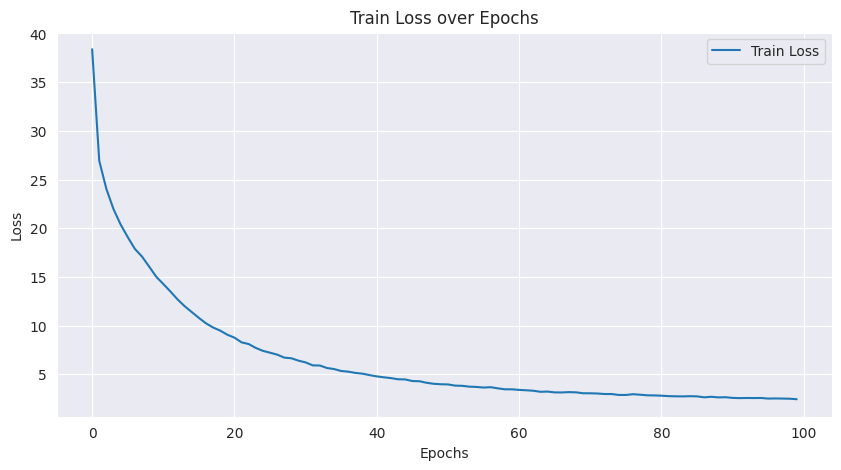

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

plt.figure(figsize=(10, 5))
plt.plot(losses, label='Train Loss')
plt.title('Train Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

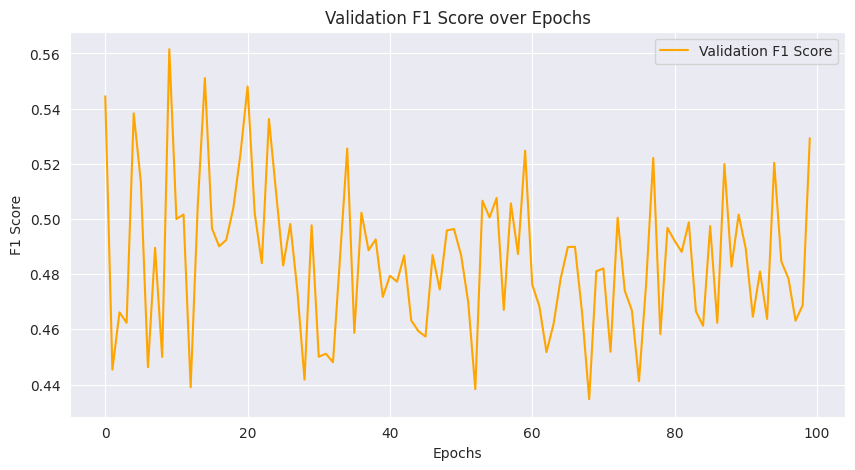

In [24]:
f1_scores = [train_history[i]['val_f1'] for i in range(len(train_history))]
plt.figure(figsize=(10, 5))
plt.plot(f1_scores, label='Validation F1 Score', color='orange')
plt.title('Validation F1 Score over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

In [26]:
print(train_history[-1]['report'])

              precision    recall  f1-score   support

      ANIMAL       0.64      0.16      0.25        58
    ARTIFACT       0.34      0.36      0.35        96
       ASSET       0.00      0.00      0.00         0
     BIOLOGY       0.21      0.17      0.19        24
  DISCIPLINE       0.19      0.14      0.16        37
     DISEASE       0.53      0.40      0.46        60
       EVENT       0.63      0.63      0.63      1454
        FOOD       0.25      0.25      0.25        36
       GROUP       0.16      0.06      0.09       206
    LANGUAGE       0.28      0.39      0.32       423
         LAW       0.29      0.01      0.02       186
         LOC       0.39      0.32      0.35       232
     MEASURE       0.29      0.19      0.23       167
       MEDIA       0.49      0.46      0.48      1427
       MONEY       0.02      0.01      0.01       217
         ORG       0.32      0.41      0.36       540
        PART       0.22      0.20      0.21        51
         PER       0.64    